# ExoPredict-Data Analysis

# Pre-Processing


In [1]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [2]:
# Import findspark and initialise.
import findspark
findspark.init()

In [3]:
# Upload the Cleaned Dataset file from output
from google.colab import files
uploaded = files.upload()

Saving Cleaned_Dataset.csv to Cleaned_Dataset.csv


In [4]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("ExoPlanet_ETL_Project").getOrCreate()

In [5]:
# Read the file
file_path = "Cleaned_Dataset.csv"

df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)
df.show(5)

+-----------+---------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+--------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+--------------------+--------------------+----------------------+------------------------+
|Planet_Name|Host_Star|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU|Planet_Radius_Earth|pl_radj|Planet_Mass_Earth|pl_bmassj|pl_bmasspr

#### Data Analysis
 1. **How do planetary characteristics influence the likelihood of being in the habitable zone? (Mandeep)**

 Answer: The habitable zone (HZ) depends on the semi-major axis (AU) and star temperature (K).
We'll classify planets as potentially habitable based on their distance from the star (semi-major axis) and the equilibrium temperature.

 We'll consider a planet inside the habitable zone if:
Semi-major axis (AU) falls within the range for a Sun-like star (0.38 - 1.5 AU).

 Equilibrium temperature falls between 200K and 320K.
 **2. How does a planet’s orbit impact its temperature and potential habitability?(Mandeep)**

  Answer: The orbital eccentricity and semi-major axis influence temperature variations.
We will analyze how eccentric orbits lead to temperature fluctuations and impact habitability.

 Highly eccentric orbits (e > 0.3) cause significant temperature fluctuations during different phases of orbit.
We will compare eccentric vs. circular orbits to see how temperature variability impacts habitability.

In [6]:
# Import necessary libraries
from pyspark.sql.types import IntegerType, DoubleType, DateType
from pyspark.sql.functions import col, isnan, when, count, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [7]:
# Define habitable zone classification
df = df.withColumn("Habitable_Zone_Status",
    when((col("Semi_Major_Axis_AU").between(0.38, 1.5)) &
         (col("Equilibrium_Temperature").between(200, 320)),
         "Potentially Habitable").otherwise("Not Habitable"))

# Count habitable vs. non-habitable planets
df.groupBy("Habitable_Zone_Status").count().show()

+---------------------+-----+
|Habitable_Zone_Status|count|
+---------------------+-----+
| Potentially Habit...|    7|
|        Not Habitable| 1123|
+---------------------+-----+



In [16]:
# Save habitable classification
df.select("Planet_Name", "Semi_Major_Axis_AU", "Equilibrium_Temperature", "Habitable_Zone_Status") \
  .write.csv("habitable_analysis.csv", header=True)

In [35]:
# Load data
df_habitable_pd = pd.read_csv("habitable_analysis.csv")


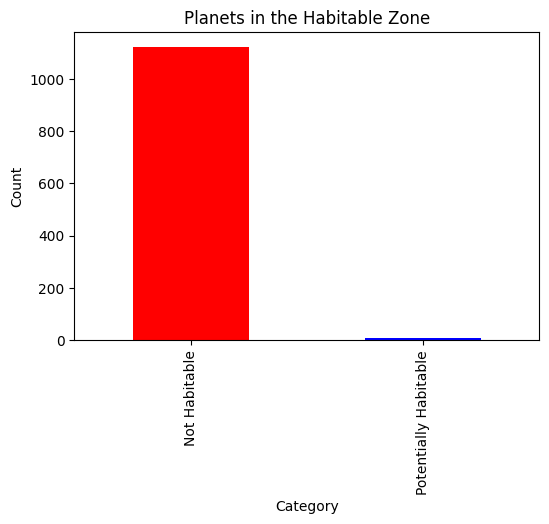

In [36]:
# Plot Habitable vs. Non-Habitable Planets
plt.figure(figsize=(6,4))
df["Habitable_Zone_Status"].value_counts().plot(kind='bar', color=['red', 'blue'])
plt.title("Planets in the Habitable Zone")
plt.xlabel("Category")
plt.ylabel("Count")
plt.savefig("habitable_vs_non_habitable_planets.png")
plt.show()

In [23]:
# Check and update the datatype for SQL Loading process
df_habitable_pd.dtypes

,0
Semi_Major_Axis_AU,float64
Equilibrium_Temperature,int32
Habitable_Zone_Status,object


In [24]:
#Analyze Orbital Eccentricity Impact on Temperature
#Classification: highly Eccentric:e >0.3, Circular/Stable: e < 0.3
df = df.withColumn("Orbit_Type",
    when(col("Orbital_Eccentricity") > 0.3, "Highly Eccentric").otherwise("Circular/Stable"))

# Show results
df.select("Planet_Name", "Orbital_Eccentricity", "Equilibrium_Temperature", "Orbit_Type").show(10)

+-----------+--------------------+-----------------------+----------------+
|Planet_Name|Orbital_Eccentricity|Equilibrium_Temperature|      Orbit_Type|
+-----------+--------------------+-----------------------+----------------+
|  GJ 1132 b|              0.0118|                    584| Circular/Stable|
|HD 136352 b|                 0.0|                    905| Circular/Stable|
|   K2-292 b|                0.04|                    795| Circular/Stable|
| TOI-1221 b|                0.21|                    440| Circular/Stable|
|     K2-3 d|               0.091|                    305| Circular/Stable|
|  TOI-157 b|                 0.0|                   1588| Circular/Stable|
|HD 260655 c|               0.038|                    557| Circular/Stable|
| TOI-2134 b|                0.06|                    666| Circular/Stable|
|   K2-266 e|               0.043|                    490| Circular/Stable|
| TOI-1448 b|                0.36|                    426|Highly Eccentric|
+-----------

In [25]:
# Save orbit eccentricity impact
df.select("Planet_Name", "Orbital_Eccentricity", "Equilibrium_Temperature", "Orbit_Type") \
  .write.csv("orbit_temperature_analysis.csv", header=True)

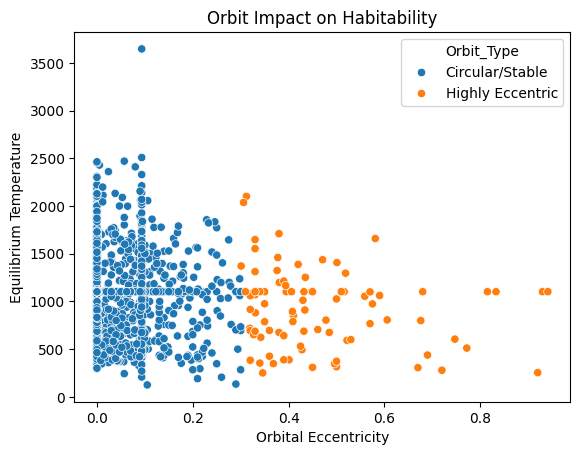

In [31]:
 #Orbit Impact on Habitability ---
df_orbit = df.select("Planet_Name", "Orbital_Eccentricity", "Equilibrium_Temperature", "Orbit_Type")
#Convert to Pandas for Visualisation
df_orbit_pd = df_orbit.toPandas()

sns.scatterplot(data=df_orbit_pd, x='Orbital_Eccentricity', y='Equilibrium_Temperature', hue='Orbit_Type')
plt.xlabel("Orbital Eccentricity")
plt.ylabel("Equilibrium Temperature")
plt.title("Orbit Impact on Habitability")
plt.savefig("orbit_temperature_analysis.png")
plt.show()



In [32]:
df_orbit_pd.dtypes

,0
Planet_Name,object
Orbital_Eccentricity,float64
Equilibrium_Temperature,int32
Orbit_Type,object


Q1 & Q2: Classify planets by insolation, temperature, mass, coordinates with regards of available planets (Iaroslav)
Complete dataset, it'll be helpful to draw graphics with stars located across sphere (Iaroslav)

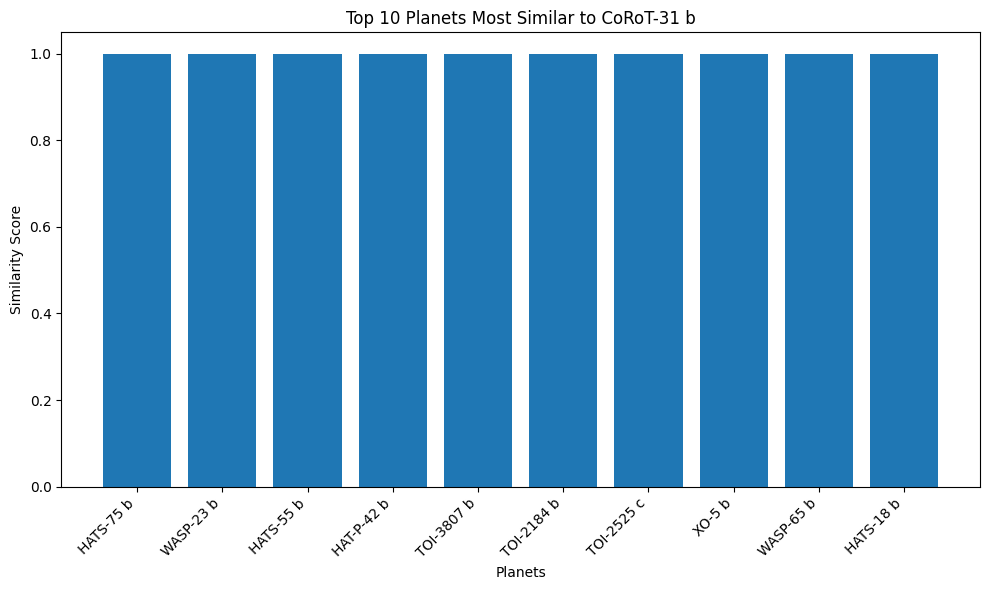

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../ml_iaroslav"))
from rank_planets5 import planet_rank_by_similarity, plot_similarity_ranking

planet_name = "CoRoT-31 b"
ranks = planet_rank_by_similarity(planet_name, file_path="../Output/CSV_Files/Cleaned Dataset.csv", output_dir='../Output/CSV_Files', features=["Planet_Mass_Earth", "Equilibrium_Temperature", "ra"])
plot_similarity_ranking(rankings=ranks, reference_planet=planet_name, output_dir="../Output/Visualisations")

In [ ]:
import sys
import os
sys.path.append(os.path.abspath("../ml_iaroslav"))
from rank_stars import load_and_normalize_dataset, rank_by_similarity, plot_similarity_ranking

selected_star = "Kepler-107"  # Change this to any star in dataset
# Rank and plot stars by similarity to the selected star
X_normalized, df = load_and_normalize_dataset(file_path="../Output/CSV_Files/Cleaned Dataset.csv", output_dir='../Output/CSV_Files', features=['Star_Temperature_K', 'Star_Radius_Solar', 'Star_Mass_Solar'])
rankings = rank_by_similarity(X_normalized, selected_star, df)
plot_similarity_ranking(output_dir="../Output/Visualisations", rankings=rankings, reference_star=selected_star)

# Patrick
Question 1: Can we identify groups of similar exoplanets?
Analysis: Apply clustering algorithms (e.g., K-means, hierarchical clustering) to group planets with similar characteristics.
Question 2: Can we classify planets into different categories (e.g., rocky planets, gas giants) based on their properties?
Analysis: Use supervised learning algorithms to classify planets based on features such as mass, radius, and temperature.

In [ ]:
# # --- Question 1: Clustering Exoplanets ---
# df = df.withColumnRenamed("Planet_Radius_Earth", "radius").withColumnRenamed("Planet_Mass_Earth", "mass").withColumnRenamed("Equilibrium_Temperature", "temperature").withColumnRenamed("Semi_Major_Axis_AU", "semi_major_axis")

# features = ['radius', 'mass', 'temperature', 'semi_major_axis']
# vector_assembler = VectorAssembler(inputCols=features, outputCol='features')
# df_features = vector_assembler.transform(df)

# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
# df_scaled = scaler.fit(df_features).transform(df_features)

# kmeans = KMeans(featuresCol='scaledFeatures', k=3, seed=42)
# kmeans_model = kmeans.fit(df_scaled)
# df_clusters = kmeans_model.transform(df_scaled)
# df_clusters.select('Planet_Name', 'prediction').show(10)

# # Convert to pandas for visualisation
# df_clusters_pd = df_clusters.toPandas()
# sns.scatterplot(data=df_clusters_pd, x=df_clusters_pd['radius'], y=df_clusters_pd['mass'], hue=df_clusters_pd['prediction'])
# plt.savefig("clustering_visualization.png")
# plt.show()

# # Save the results
# df_clusters.toPandas().to_csv("clustering_results.csv", index=False)

In [ ]:
# # --- Question 2: Classification of Planets ---
# df_class = df.select('radius', 'mass', 'temperature', 'Discovery_Method')

# # Convert string column to numeric
# indexer = StringIndexer(inputCol="Discovery_Method", outputCol="Discovery_Method_Index")
# df_class = indexer.fit(df_class).transform(df_class)

# vector_assembler_class = VectorAssembler(inputCols=['radius', 'mass', 'temperature'], outputCol='features')
# df_class_features = vector_assembler_class.transform(df_class)

# rf = RandomForestClassifier(labelCol='Discovery_Method_Index', featuresCol='features', numTrees=10)
# rf_model = rf.fit(df_class_features)
# df_pred = rf_model.transform(df_class_features)

# evaluator = MulticlassClassificationEvaluator(labelCol="Discovery_Method_Index", predictionCol="prediction", metricName="accuracy")
# accuracy = evaluator.evaluate(df_pred)
# print(f"Classification Accuracy: {accuracy}")


# #Convert to Pandas for Visualisation
# df_pred_pd = df_pred.select("Discovery_Method_Index", "prediction").toPandas()
# sns.histplot(data=df_pred_pd, x='prediction', kde=True)
# plt.xlabel("Predicted Class")
# plt.ylabel("Frequency")
# plt.title("Distribution of Predicted Planet Types")
# plt.savefig("classification_visualization.png")
# plt.show()


# # Save classification results
# df_pred.toPandas().to_csv("classification_results.csv", index=False)

In [ ]:
#Export CSV and visualisations


#### Question 7
Which exoplanet discovery method has been used the most, and which has been used the least? What does this indicate about the effectiveness and prevalence of different detection techniques? (Amrit)


In [ ]:
clean_df = df.cache()

In [ ]:
# Check the cached dataframe
clean_df.show(2)

+---------------+-------------+-----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+--------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+----------+------------------+-----------------------+-------------------------+--------------+--------------------+--------------------+----------------------+------------------------+
|    Planet_Name|    Host_Star|Num_Planets|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU|Planet_Radius_Earth|pl_radj

In [ ]:
# Assuming clean_df is your PySpark DataFrame
clean_df_1 = clean_df.select("Discovery_Method", "Discovery_Facility", "Host_Star", "Discovery_Year")

# Convert PySpark DataFrame to Pandas
pandas_df = clean_df_1.toPandas()

pandas_df.head(2)

,Discovery_Method,Discovery_Facility,Host_Star,Discovery_Year
0,Transit,Kepler,Kepler-138,2014
1,Transit,Transiting Exoplanet Survey Satellite (TESS),TIC 139270665,2024


In [ ]:
# Find the most used discovery method
disc_method_max = pandas_df["Discovery_Method"].value_counts().idxmax()

# Find the least used discovery method
disc_method_min = pandas_df["Discovery_Method"].value_counts().idxmin()

# Count the total number of discoveries using the 'Transit' method
length_max = (pandas_df["Discovery_Method"] == "Transit").sum()

# Count the total number of discoveries using the 'Transit Timing Variations' method
length_min = (pandas_df["Discovery_Method"] == "Transit Timing Variations").sum()

print("Most used discovery method:", disc_method_max)
print("Least used discovery method:", disc_method_min)
print("Total number of discoveries using Transit method:",length_max)
print("Total number of discoveries using Transit Timing Variations:", length_min)

Most used discovery method: Transit
Least used discovery method: Transit Timing Variations
Total number of discoveries using Transit method: 1102
Total number of discoveries using Transit Timing Variations: 1


In [ ]:
# Check the datatype
pandas_df.dtypes

,0
Discovery_Method,object
Discovery_Facility,object
Host_Star,object
Discovery_Year,int32


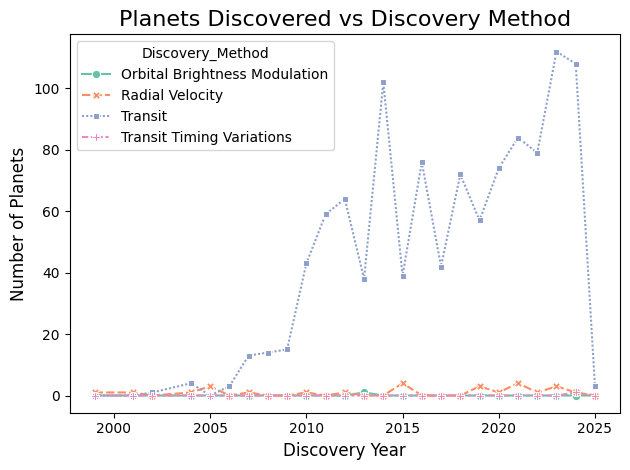

In [ ]:
# Save the Pandas DataFrame to a CSV file
pandas_df.to_csv("Planets_vs_discovery_method.csv", index=False)

# Count the number of planets discovered per year for each method
planet_counts = pandas_df.groupby(['Discovery_Year', 'Discovery_Method']).size().unstack(fill_value=0)

# Create a line plot comparing the four methods
plt.figure()
sns.lineplot(data=planet_counts, palette="Set2", markers=True)

# Set labels and title
plt.title("Planets Discovered vs Discovery Method", fontsize=16)
plt.xlabel("Discovery Year", fontsize=12)
plt.ylabel("Number of Planets", fontsize=12)

# Save the plot as a PNG file
plt.tight_layout()
plt.savefig("Planets Discovered vs Discovery Method.png")

# Show the plot
plt.show()


#### Answer
 Transit is the most dominant method for discovering exoplanets, while Transit Timing Variations (TTV) is the least used.

- Transit (1102 discoveries) → Most widely used method, likely due to missions like Kepler and TESS, which monitor star brightness dips when planets pass in front.
- Transit Timing Variations (1 discovery) → Rarely used, likely because it requires detecting minute gravitational influences on already-known planets.

This analysis highlights the dominance of large-scale transit surveys and the rarity of more specialized detection techniques like TTV

#### Question 8
How does the distance of a planet host from its exoplanets influence the exoplanets' temperature, luminosity?

In [ ]:
clean_df.show(2)

+---------------+-------------+-----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+--------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+------------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+----------+------------------+-----------------------+-------------------------+--------------+--------------------+--------------------+----------------------+------------------------+
|    Planet_Name|    Host_Star|Num_Planets|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU|Planet_Radius_Earth|pl_radj

In [ ]:
# Create a temporary view of the dataframe
clean_df.createOrReplaceTempView('discovery_method')

In [ ]:
result_2 = spark.sql("""
    SELECT Planet_Name, System_Distance_PC,Equilibrium_Temperature, System_Infrared_Magnitude
    FROM discovery_method
""")
result_2.show(2)

+---------------+------------------+-----------------------+-------------------------+
|    Planet_Name|System_Distance_PC|Equilibrium_Temperature|System_Infrared_Magnitude|
+---------------+------------------+-----------------------+-------------------------+
|   Kepler-138 c|           66.8624|                    410|                    9.506|
|TIC 139270665 b|           189.875|                    703|                    8.946|
+---------------+------------------+-----------------------+-------------------------+
only showing top 2 rows



In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df_1 = result_2.toPandas()

In [ ]:
import pandas as pd

# Find the maximum and minimum system distances
max_dist = pandas_df_1["System_Distance_PC"].max()
min_dist = pandas_df_1["System_Distance_PC"].min()

# Find the planet name, star temperature, brightness, and infrared magnitude corresponding to max and min distances
planet_max_dist = pandas_df_1.loc[
    pandas_df_1["System_Distance_PC"] == max_dist,
    ["Planet_Name", "Equilibrium_Temperature", "System_Infrared_Magnitude"]
].values[0]

planet_min_dist = pandas_df_1.loc[
    pandas_df_1["System_Distance_PC"] == min_dist,
    ["Planet_Name", "Equilibrium_Temperature", "System_Infrared_Magnitude"]
].values[0]

# Print the results
print("Planet with maximum distance:", planet_max_dist[0], "| Distance:", max_dist,
      "| Planet Temperature:", planet_max_dist[1], "| Planet Luminosity:", planet_max_dist[2])

print("Planet with minimum distance:", planet_min_dist[0], "| Distance:", min_dist,
      "| Planet Temperature:", planet_min_dist[1], "| Planet Luminosity:", planet_min_dist[2])




Planet with maximum distance: OGLE-TR-182 b | Distance: 2501.75 | Planet Temperature: 1102 | Planet Luminosity: 14.737
Planet with minimum distance: HD 219134 b | Distance: 6.53127 | Planet Temperature: 1015 | Planet Luminosity: 3.261


In [ ]:
# Check the datatype
pandas_df_1.dtypes

,0
Planet_Name,object
System_Distance_PC,float64
Equilibrium_Temperature,int32
System_Infrared_Magnitude,float64


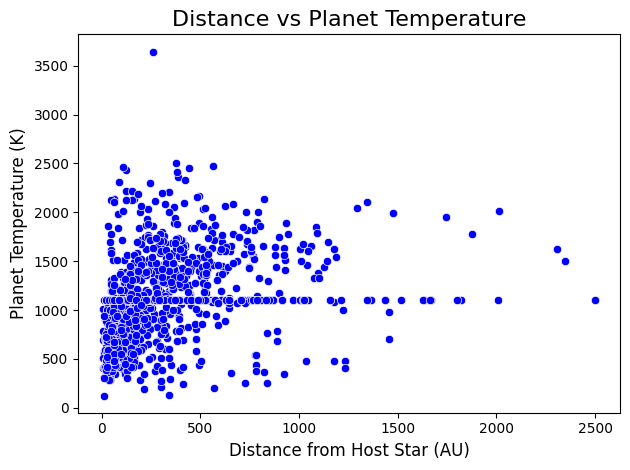

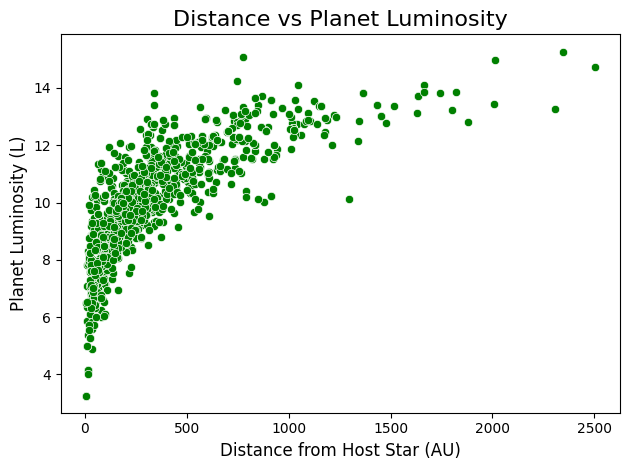

In [ ]:
# Save the Pandas DataFrame to a CSV file
pandas_df_1.to_csv("Distance_temp_luminosity.csv", index=False)

# 1. Scatter plot for Distance vs Temperature
plt.figure()
sns.scatterplot(x='System_Distance_PC', y='Equilibrium_Temperature', data=pandas_df_1, color='blue')
plt.title("Distance vs Planet Temperature", fontsize=16)
plt.xlabel("Distance from Host Star (AU)", fontsize=12)
plt.ylabel("Planet Temperature (K)", fontsize=12)
plt.tight_layout()
plt.savefig("distance_vs_temperature.png")
plt.show()

# 2. Scatter plot for Distance vs Luminosity
plt.figure()
sns.scatterplot(x='System_Distance_PC', y='System_Infrared_Magnitude', data=pandas_df_1, color='green')
plt.title("Distance vs Planet Luminosity", fontsize=16)
plt.xlabel("Distance from Host Star (AU)", fontsize=12)
plt.ylabel("Planet Luminosity (L)", fontsize=12)
plt.tight_layout()
plt.savefig("distance_vs_luminosity.png")
plt.show()



### Answer

The analysis compares the exoplanets OGLE-TR-182 b (farthest from its star at 2501.75 light-years) and HD 219134 b (closest at 6.53 light-years).

It suggests that both exoplanets despite being farthest and closest to their host, are both depict high temperature where as the luminosity difference is apparently high in the exoplanet closest to its star at 14.737.

However, analyzing the visualizations reveals a clear inverse relationship between an exoplanet’s distance from its host star and its temperature. Planets closer to their stars tend to be hotter, while those farther away are cooler, following established astrophysical principles. This study highlights extreme planetary diversity, where distant gas giants and nearby rocky planets provide unique opportunities for exoplanetary science.